## This notebook can be used to rank a list of nodes from a category that connect to an entity such as a gene. 
#### Example 1: Which disease are associate with NPM1 gene?
#### Example 2: Which proteins interacts with protein NPM1?
#### Example 3: Which drugs or small molecules can interact with NPM1?


In [1]:
import sys
sys.path.append('../TCT')
import TCT as TCT
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import requests

In [2]:
# Step1: List all the APIs in the translator system
Translator_KP_info,APInames= TCT.get_SmartAPI_Translator_KP_info()
Translator_KP_info.to_csv('SmartAPI_Translator_KP_info.csv', index=False)
print(len(Translator_KP_info))

53


In [3]:
# Step 2: Get metaKG and all predicates from Translator APIs
metaKG = TCT.get_KP_metadata(APInames) # This only applies to the Translator APIs  # This need revision because of the metaKG information changes from the SmartAPI team
#print(metaKG.columns)
#metaKG.to_csv('../metaData/metaKG.csv', index=False)
#metaKG = pd.read_csv('../metaData/metaKG.csv')
print(metaKG.shape)
All_predicates = list(set(metaKG['KG_category']))
All_categories = list((set(list(set(metaKG['Subject']))+list(set(metaKG['Object'])))))

(10580, 5)


In [ ]:
#len(set(Translator_KP_info['title']))
Translator_KP_info['title']

0                ARAX Translator Reasoner - TRAPI 1.5.0
1                        BioThings Explorer (BTE) TRAPI
2                         imProving Agent for TRAPI 1.5
3                           Text Mined Cooccurrence API
4                                 RTX KG2 - TRAPI 1.5.0
5                           Microbiome KP - TRAPI 1.5.0
6                                            COHD TRAPI
7              CATRAX Pharmacogenomics KP - TRAPI 1.5.0
8                   Connections Hypothesis Provider API
9                                Service Provider TRAPI
10                   Automat-drug-central(Trapi v1.5.0)
11    Genetics Data Provider for NCATS Biomedical Tr...
12                Gene-List Network Enrichment Analysis
13                                              MolePro
14                          Text Mined Cooccurrence API
15                      Drug Approvals KP - TRAPI 1.5.0
16                          Knowledge Collaboratory API
17                                    Cqs(Trapi 

In [8]:
# Step 3: set input parameters
# Test multiomics BigGIM Drug Response KP
# Node1 for query
input_node1 = 'FLT3'
input_node1_id = TCT.get_curie(input_node1)
print(input_node1_id)
input_node1_list = [input_node1_id]
input_node1_category = ['biolink:Gene'] # Node: this has to be in a format of biolink:xxx

#Node2 for query
input_node2_list = []
input_node2_category = ['biolink:Drug', 'biolink:SmallMolecule', 'biolink:ChemicalSubstance']
#input_node2_category = ['biolink:Gene']

# Get all predicates for the input node1 and node2, user can furter select the predicates among this list
sele_predicates = list(set(TCT.select_concept(sub_list=input_node1_category,
                                              obj_list=input_node2_category,
                                              metaKG=metaKG)))



print("all relevant predicates in Translator:")
print(sele_predicates)
# select predicates

# Get all APIs for the input node1 and node2, user can furter select the APIs among this list
sele_APIs = TCT.select_API(sub_list=input_node1_category,
                           obj_list=input_node2_category,
                           metaKG=metaKG)

print("all relevant APIs in Translator:")
print(sele_APIs)
print(len(sele_APIs))

# get API URLs
API_URLs = TCT.get_Translator_API_URL(sele_APIs, 
                                      APInames)

NCBIGene:2322
all relevant predicates in Translator:
['biolink:sensitivity_associated_with', 'biolink:associated_with_sensitivity_to', 'biolink:produces', 'biolink:associated_with', 'biolink:interacts_with', 'biolink:coexists_with', 'biolink:affects', 'biolink:has_gene_product', 'biolink:disrupts', 'biolink:chemically_similar_to', 'biolink:disrupted_by', 'biolink:directly_physically_interacts_with', 'biolink:response_affected_by', 'biolink:affected_by', 'biolink:decreases_response_to', 'biolink:similar_to', 'biolink:is_substrate_of', 'biolink:has_output', 'biolink:derives_from', 'biolink:output_of', 'biolink:positively_correlated_with', 'biolink:has_substrate', 'biolink:regulates', 'biolink:physically_interacts_with', 'biolink:derives_into', 'biolink:associated_with_increased_likelihood_of', 'biolink:occurs_together_in_literature_with', 'biolink:has_part', 'biolink:related_to_at_instance_level', 'biolink:affects_response_to', 'biolink:produced_by', 'biolink:part_of', 'biolink:negativel

In [10]:
# can use large language model to select predicates
sele_predicates = ['biolink:associated_with_resistance_to',
                   'biolink:associated_with_sensitivity_to', 
                   'biolink:occurs_together_in_literature_with',
                   'biolink:physically_interacts_with']

In [12]:
# Step 4: Format query json
query_json = TCT.format_query_json(input_node1_list,  # a list of identifiers for input node1
                                   input_node2_list,  # it can be empty list if only want to query node1
                                   input_node1_category,  # a list of categories of input node1
                                   input_node2_category,  # a list of categories of input node2
                                   sele_predicates) # a list of predicates
query_json

{'message': {'query_graph': {'nodes': {'n0': {'ids': ['NCBIGene:2322'],
     'categories': ['biolink:Gene']},
    'n1': {'categories': ['biolink:Drug',
      'biolink:SmallMolecule',
      'biolink:ChemicalSubstance']}},
   'edges': {'e1': {'subject': 'n0',
     'object': 'n1',
     'predicates': ['biolink:associated_with_resistance_to',
      'biolink:associated_with_sensitivity_to',
      'biolink:occurs_together_in_literature_with',
      'biolink:physically_interacts_with']}}}}}

In [13]:

# Step 5: Query Translator APIs and parse results
result = TCT.parallel_api_query(API_URLs,query_json=query_json, max_workers=len(API_URLs))

# Step 6: Parse results
result_parsed = TCT.parse_KG(result)

# Step 7: Ranking the results. This ranking method is based on the number of unique primary infores. It can only be used to rank the results with one defined node.
result_ranked_by_primary_infores = TCT.rank_by_primary_infores(result_parsed, input_node1_id)   # input_node1_id is the curie id of the input node, such as "NCBIGene:1017"


Warning Code:422:https://automat.transltr.io/ctd/query/Warning Code:404:https://molepro-trapi.transltr.io/molepro/trapi/v1.5/query/
Warning Code:422:https://automat.transltr.io/hmdb/query/

Success!https://automat.transltr.io/cam-kp/query/
Warning Code:422:https://automat.renci.org/ehr-clinical-connections-kp/query/
Success!https://automat.transltr.io/hetio/query/
Warning Code:422:https://automat.renci.org/ehr-may-treat-kp/query/
Warning Code:422:https://automat.transltr.io/icees-kg/query/
Success!https://automat.transltr.io/gtopdb/query/
Success!https://automat.transltr.io/pharos/query/
Success!https://automat.transltr.io/robokopkg/query/
Success!https://bte.transltr.io/v1/team/Service%20Provider/query/
Success!https://bte.transltr.io/v1/query/
CHEMBL.COMPOUND:CHEMBL4795462: no preferred name
CHEMBL.COMPOUND:CHEMBL4798601: no preferred name
CHEMBL.COMPOUND:CHEMBL3656365: no preferred name
CHEMBL.COMPOUND:CHEMBL3656366: no preferred name
CHEMBL.COMPOUND:CHEMBL3656369: no preferred name

In [14]:
result_ranked_by_primary_infores

,output_node,Name,Num_of_primary_infores,type_of_nodes,unique_predicates
423,CHEBI:63452,Midostaurin,5,object,"[biolink:physically_interacts_with, biolink:ph..."
421,CHEBI:78543,Ponatinib,5,object,"[biolink:physically_interacts_with, biolink:ph..."
439,CHEBI:91408,Fedratinib,4,object,"[biolink:physically_interacts_with, biolink:oc..."
422,CHEBI:91471,LSM-1231,4,object,"[biolink:physically_interacts_with, biolink:oc..."
448,CHEBI:49960,Vandetanib,4,object,"[biolink:physically_interacts_with, biolink:oc..."
...,...,...,...,...,...
1651,PUBCHEM.COMPOUND:118439773,4-[[2-(butylamino)-5-[5-[[(3R)-3-(dimethylamin...,1,object,"[biolink:physically_interacts_with, biolink:ph..."
1652,INCHIKEY:QQTWEWAFAIDGJB-MXVIHJGJSA-N,INCHIKEY:QQTWEWAFAIDGJB-MXVIHJGJSA-N,1,object,"[biolink:physically_interacts_with, biolink:ph..."
1653,PUBCHEM.COMPOUND:117849653,2-[[2-(Butylamino)-5-pyridin-2-ylpyrimidin-4-y...,1,object,"[biolink:physically_interacts_with, biolink:ph..."
1654,INCHIKEY:WORRXRIVSMTSEB-CXIWYSOXSA-N,INCHIKEY:WORRXRIVSMTSEB-CXIWYSOXSA-N,1,object,"[biolink:physically_interacts_with, biolink:ph..."


In [15]:
print(query_json)

{'message': {'query_graph': {'nodes': {'n0': {'ids': ['NCBIGene:2322'], 'categories': ['biolink:Gene']}, 'n1': {'categories': ['biolink:Drug', 'biolink:SmallMolecule', 'biolink:ChemicalSubstance']}}, 'edges': {'e1': {'subject': 'n0', 'object': 'n1', 'predicates': ['biolink:associated_with_resistance_to', 'biolink:associated_with_sensitivity_to', 'biolink:occurs_together_in_literature_with', 'biolink:physically_interacts_with']}}}}}


CHEMBL.COMPOUND:CHEMBL4795462: no preferred name
CHEMBL.COMPOUND:CHEMBL4798601: no preferred name
CHEMBL.COMPOUND:CHEMBL4764646: no preferred name
CHEMBL.COMPOUND:CHEMBL4851303: no preferred name
CHEMBL.COMPOUND:CHEMBL45177: no preferred name
CHEMBL.COMPOUND:CHEMBL4861169: no preferred name
CHEMBL.COMPOUND:CHEMBL4849169: no preferred name
CHEMBL.COMPOUND:CHEMBL4203825: no preferred name
CHEMBL.COMPOUND:CHEMBL4216043: no preferred name
CHEMBL.COMPOUND:CHEMBL4277445: no preferred name
CHEMBL.COMPOUND:CHEMBL4282510: no preferred name
CHEMBL.COMPOUND:CHEMBL4279673: no preferred name
CHEMBL.COMPOUND:CHEMBL4284541: no preferred name
CHEMBL.COMPOUND:CHEMBL4208669: no preferred name
CHEMBL.COMPOUND:CHEMBL4212241: no preferred name
CHEMBL.COMPOUND:CHEMBL3237706: no preferred name
CHEMBL.COMPOUND:CHEMBL3237707: no preferred name
CHEMBL.COMPOUND:CHEMBL3237708: no preferred name
CHEMBL.COMPOUND:CHEMBL3237709: no preferred name
CHEMBL.COMPOUND:CHEMBL3237710: no preferred name
CHEMBL.COMPOUND:CHEMBL

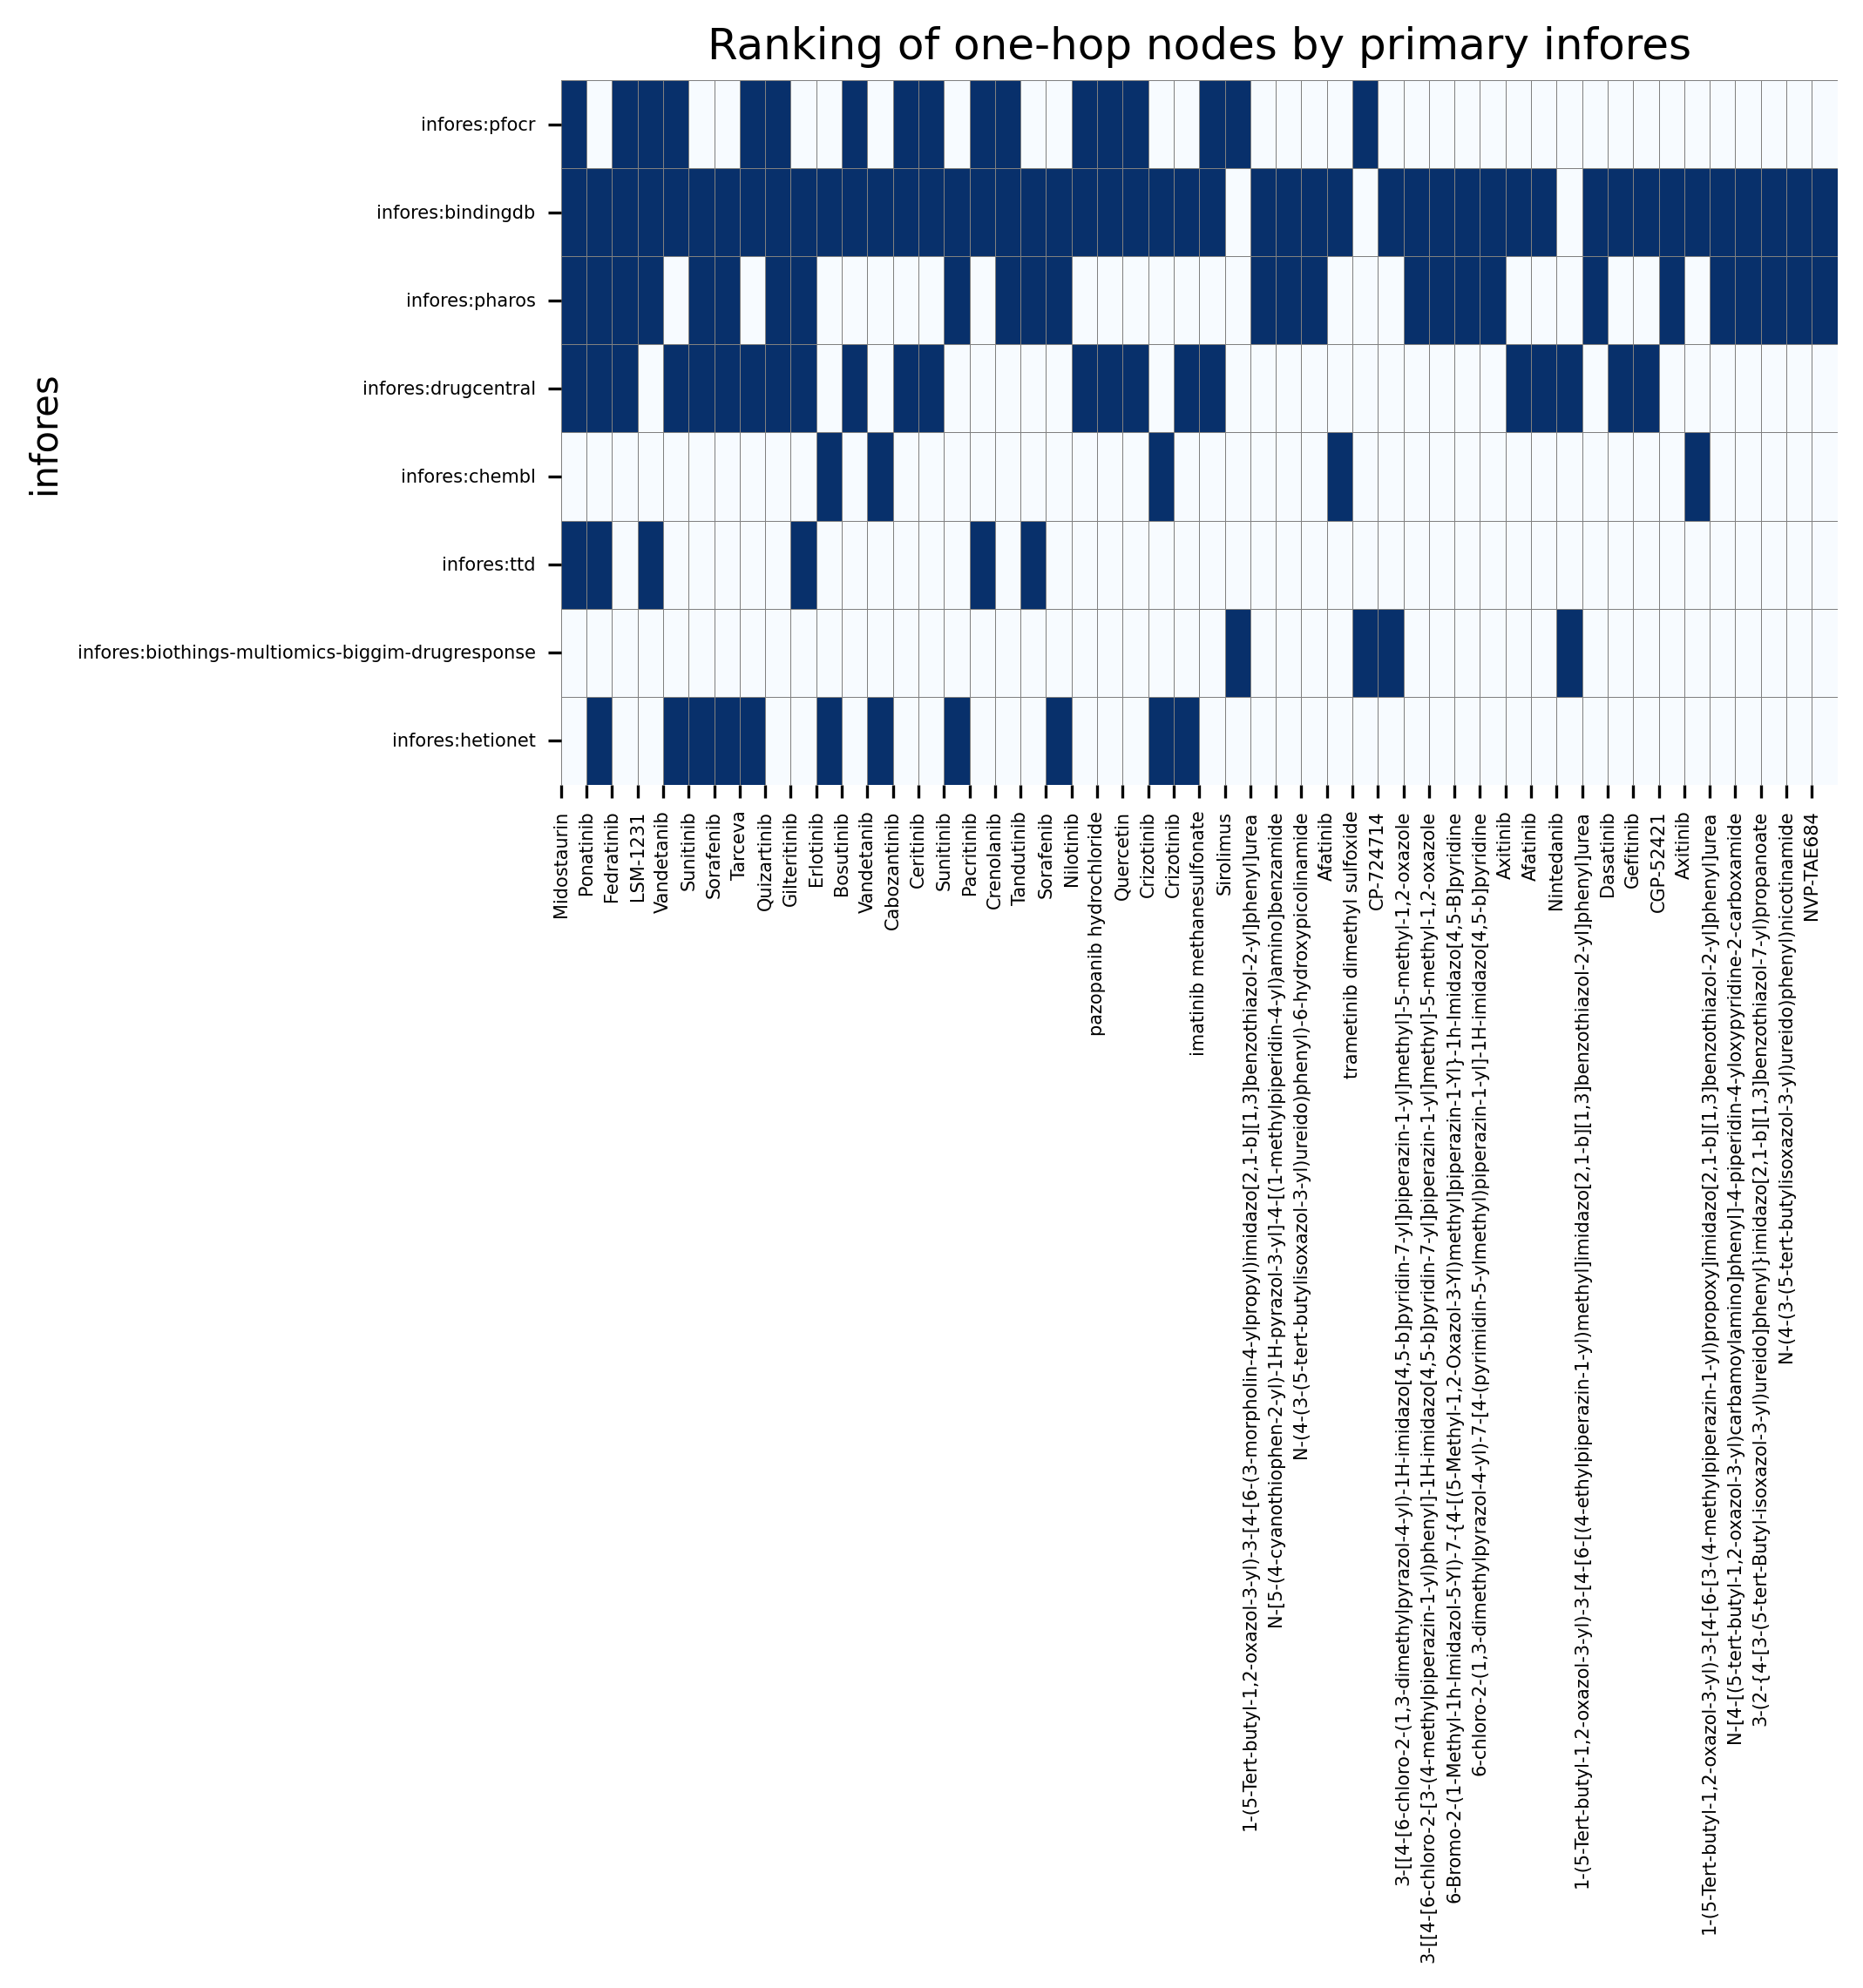

[Text(0.5, 0, 'Midostaurin'), Text(2.5, 0, 'Fedratinib'), Text(4.5, 0, 'Vandetanib'), Text(6.5, 0, 'Sorafenib'), Text(8.5, 0, 'Quizartinib'), Text(10.5, 0, 'Erlotinib'), Text(12.5, 0, 'Vandetanib'), Text(14.5, 0, 'Ceritinib'), Text(16.5, 0, 'Pacritinib'), Text(18.5, 0, 'Tandutinib'), Text(20.5, 0, 'Nilotinib'), Text(22.5, 0, 'Quercetin'), Text(24.5, 0, 'Crizotinib'), Text(26.5, 0, 'Sirolimus'), Text(28.5, 0, 'N-[5-(4-cyanothiophen-2-yl)-1H-pyrazol-3-yl]-4-[(1-methylpiperidin-4-yl)amino]benzamide'), Text(30.5, 0, 'Afatinib'), Text(32.5, 0, 'CP-724714'), Text(34.5, 0, '3-[[4-[6-chloro-2-[3-(4-methylpiperazin-1-yl)phenyl]-1H-imidazo[4,5-b]pyridin-7-yl]piperazin-1-yl]methyl]-5-methyl-1,2-oxazole'), Text(36.5, 0, '6-chloro-2-(1,3-dimethylpyrazol-4-yl)-7-[4-(pyrimidin-5-ylmethyl)piperazin-1-yl]-1H-imidazo[4,5-b]pyridine'), Text(38.5, 0, 'Afatinib'), Text(40.5, 0, '1-(5-Tert-butyl-1,2-oxazol-3-yl)-3-[4-[6-[(4-ethylpiperazin-1-yl)methyl]imidazo[2,1-b][1,3]benzothiazol-2-yl]phenyl]urea'), Text(

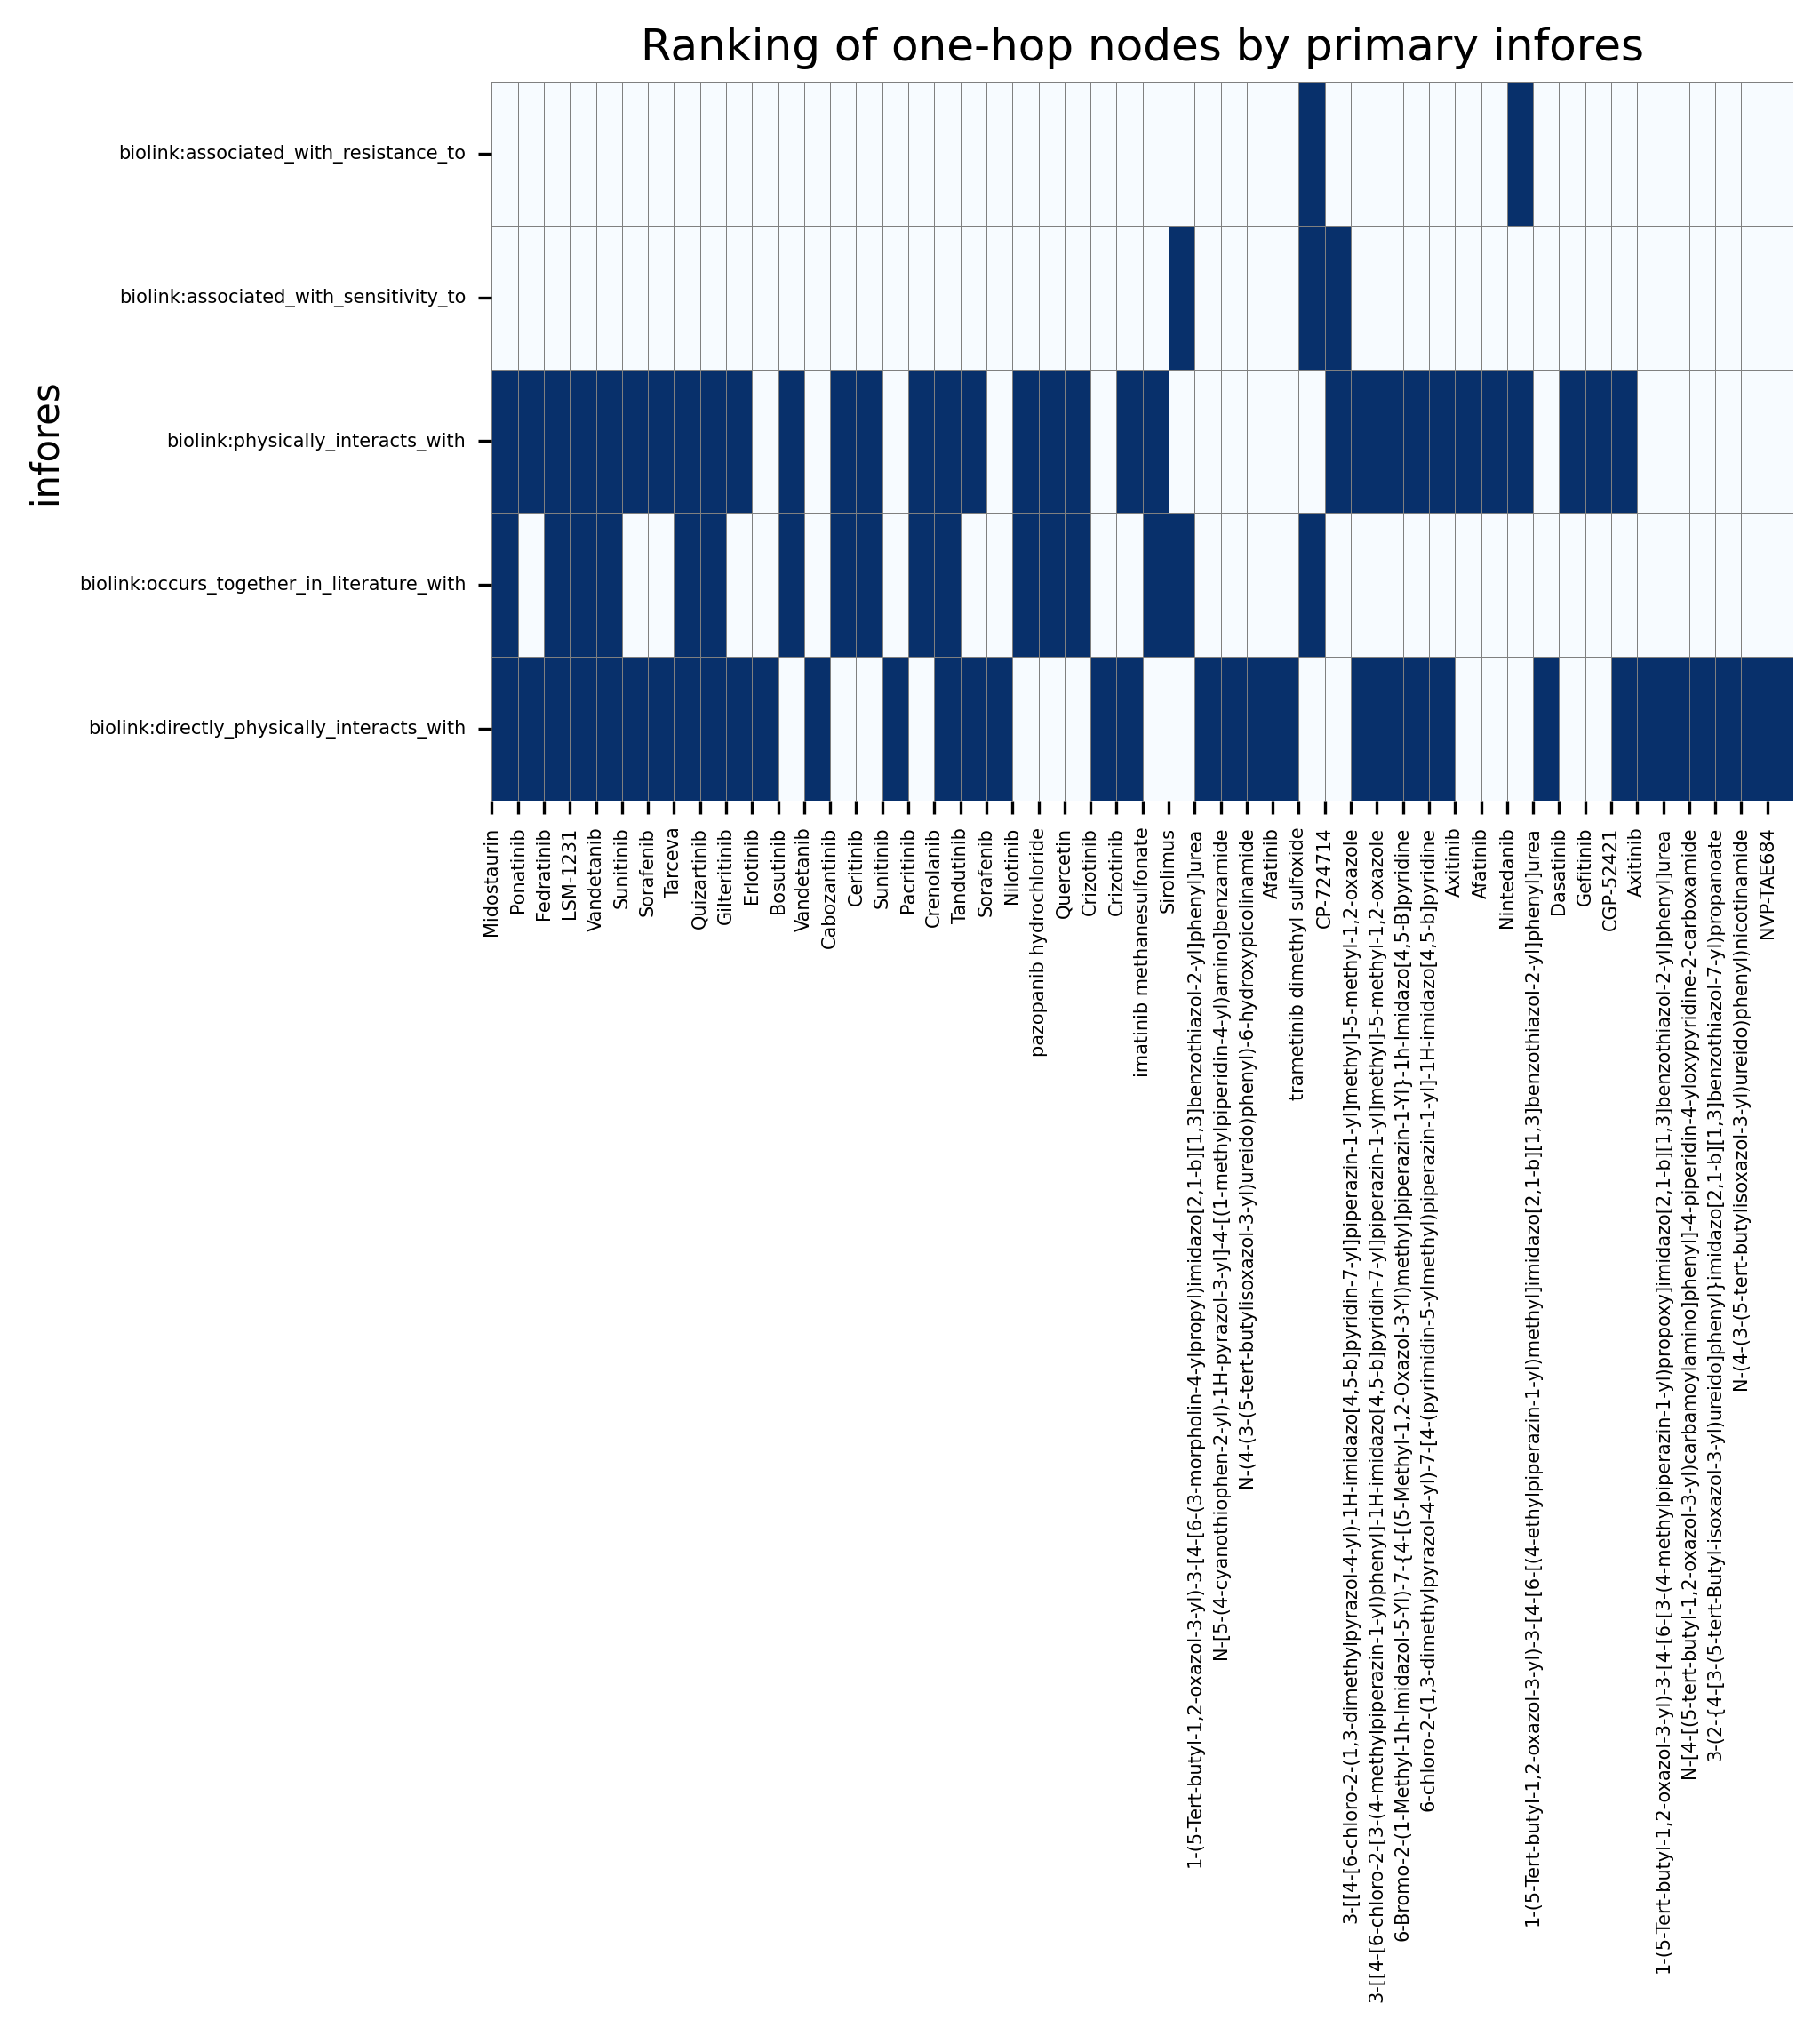

,Midostaurin,Ponatinib,Fedratinib,LSM-1231,Vandetanib,Sunitinib,Sorafenib,Tarceva,Quizartinib,Gilteritinib,...,INCHIKEY:TVOBCJAKLFDOFL-WEBLMRDCSA-N,INCHIKEY:VXGYSGCTPBOVEG-CXIWYSOXSA-N,INCHIKEY:KQTRQDMQBAIPKT-HDJSIYSDSA-N,INCHIKEY:RXNGZWXHXININL-IBFNMHAXSA-N,INCHIKEY:GMAFXYZWTSGYMU-LCKWQUASSA-N,4-[[2-(butylamino)-5-[5-[[(3R)-3-(dimethylamino)pyrrolidin-1-yl]methyl]pyridin-2-yl]pyrimidin-4-yl]amino]cyclohexan-1-ol,INCHIKEY:QQTWEWAFAIDGJB-MXVIHJGJSA-N,2-[[2-(Butylamino)-5-pyridin-2-ylpyrimidin-4-yl]amino]ethanol,INCHIKEY:WORRXRIVSMTSEB-CXIWYSOXSA-N,FLT3-IN-5e
biolink:associated_with_resistance_to,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:associated_with_sensitivity_to,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
biolink:physically_interacts_with,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
biolink:occurs_together_in_literature_with,1,0,1,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
biolink:directly_physically_interacts_with,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1


In [16]:
# Step 8: Visualize the results
TCT.visulization_one_hop_ranking(result_ranked_by_primary_infores, result_parsed, 
                                num_of_nodes = 50, input_query = input_node1_id, 
                                fontsize = 5)


In [12]:
# End of the example